# Weather-Enhanced Solar Forecasting

🌤️ **Advanced solar production forecasting using weather data and machine learning**

This notebook demonstrates how to integrate weather data to dramatically improve solar production forecasting accuracy. We'll use multiple weather APIs, analyze weather impact on solar performance, and create ML models that incorporate weather conditions.

## Features Covered:
- 🌍 **Weather API Integration** - Free Open-Meteo and premium OpenWeatherMap
- 📊 **Weather Impact Analysis** - Correlation analysis between weather and production
- 🤖 **ML-Enhanced Forecasting** - Weather-aware prediction models
- ⚡ **Production Optimization** - Identify optimal weather conditions
- 📈 **7-Day Forecasts** - Weather-based production predictions

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🌤️ Weather-Enhanced Solar Forecasting")
print("=" * 50)

🌤️ Weather-Enhanced Solar Forecasting


In [ ]:
# Import our custom modules
import sys
sys.path.append('../src')

from core.data_manager import SolarDataManager
from core.location_loader import create_notebook_location_with_rates
from core.weather_manager import WeatherManager, WeatherProvider
from core.weather_analysis import WeatherAnalyzer
from core.data_source_detector import DataSourceDetector

print("✅ All modules imported successfully")

## 🌍 Setup Location and Weather Services

First, let's configure our location and initialize weather services. The system will automatically detect your location from the `.env` file or use Denver as a fallback.

In [3]:
# Load location and electricity rates configuration
location, electricity_rates = create_notebook_location_with_rates()

print(f"📍 Location: {location.location_name}")
print(f"   Coordinates: {location.latitude:.3f}, {location.longitude:.3f}")
print(f"   Timezone: {location.timezone_str}")
print(f"   Electricity rate: {electricity_rates['residential_rate']:.2f}¢/kWh")

# Initialize weather services
weather_manager = WeatherManager()
weather_analyzer = WeatherAnalyzer()

# Check available weather providers
weather_summary = weather_manager.get_weather_summary(location.latitude, location.longitude)
print(f"\n🌤️ Available Weather Providers:")
for provider in weather_summary['available_providers']:
    print(f"   • {provider['name']} ({provider['type']}) - {provider['forecast_days']} day forecast")

print(f"\n🎯 Weather Capabilities:")
for capability, available in weather_summary['capabilities'].items():
    status = "✅" if available else "❌"
    print(f"   {status} {capability.replace('_', ' ').title()}: {available}")

📍 Location: Holly Springs, NC
   Coordinates: 35.668, -78.850
   Timezone: America/New York
   Electricity rate: 14.15¢/kWh

🌤️ Available Weather Providers:
   • Open-Meteo (free) - 16 day forecast

🎯 Weather Capabilities:
   ✅ Forecast Days: 16
   ✅ Historical Data: True
   ✅ Solar Irradiance: True
   ✅ Hourly Data: True


## 📊 Load Solar Production Data

This notebook can automatically detect and use different data sources in priority order:

1. **🎯 REAL API DATA** - Your actual Enphase solar system (requires .env setup)
2. **📈 REAL CSV DATA** - Historical CSV files from your system  
3. **🎭 SYNTHETIC DATA** - Generated demo data for your location

### 🔧 To Use Your Real Solar Data:
1. Copy `.env.template` to `.env`: `cp .env.template .env`
2. Register at https://developer.enphase.com/ and get your credentials
3. Run: `uv run python src/setup/oauth_setup.py` for OAuth tokens
4. Update `.env` with your actual credentials

The system will automatically detect your credentials and prioritize real data!

In [ ]:
# Initialize data manager and load solar data using smart data source detection
from core.data_source_detector import DataSourceDetector

# Initialize the smart data source detector
detector = DataSourceDetector(location=location)

# Determine the optimal data loading strategy
strategy = detector.determine_data_strategy()

# Initialize data manager with the detected strategy
try:
    data_manager = SolarDataManager(
        csv_path=strategy['csv_path'], 
        enphase_client=strategy['client']
    )
    
    # Load production data
    daily_data = data_manager.get_daily_production()
    data_summary = data_manager.get_data_summary()
    
    # Analyze data recency and authenticity
    recency_info = detector.analyze_data_recency(daily_data, data_summary)
    
    # Generate comprehensive data source report
    detector.generate_final_report(strategy, data_summary, recency_info)
    
    print(f"   📊 Total days analyzed: {len(daily_data)}")
    print(f"   ⚡ Average daily production: {daily_data['Production (kWh)'].mean():.1f} kWh")
    
except Exception as e:
    print(f"⚠️ Error loading data: {e}")
    print("Generating sample data for demonstration...")
    
    # Generate sample data if needed
    import pandas as pd
    import numpy as np
    dates = pd.date_range('2024-01-01', periods=90, freq='D')
    production = np.random.normal(25, 8, 90).clip(0, 60)  # 0-60 kWh daily
    daily_data = pd.DataFrame({'Production (kWh)': production}, index=dates)
    
    print(f"📊 Generated sample data: {len(daily_data)} days")

# Display recent production data
print(f"\n📅 Recent Production Data:")
print(daily_data[['Production (kWh)']].tail())

## 🌤️ Fetch Current Weather Data

Let's get current weather conditions and a 7-day forecast for your location using the free Open-Meteo API.

In [5]:
# Get current weather forecast
print("🌤️ Fetching Weather Forecast...")

try:
    # Get 7-day weather forecast with solar irradiance
    forecast_weather = weather_manager.get_weather_forecast(
        latitude=location.latitude,
        longitude=location.longitude,
        days=7,
        provider=WeatherProvider.OPEN_METEO
    )
    
    # Get solar irradiance forecast
    solar_forecast = weather_manager.get_solar_irradiance_forecast(
        latitude=location.latitude,
        longitude=location.longitude,
        days=7
    )
    
    print(f"✅ Weather forecast loaded: {len(forecast_weather)} data points")
    print(f"✅ Solar irradiance forecast: {len(solar_forecast)} hours")
    
    # Display current conditions (first data point)
    current = forecast_weather[0]
    print(f"\n🌡️ Current Weather Conditions:")
    print(f"   Temperature: {current.temperature:.1f}°C")
    print(f"   Humidity: {current.humidity:.0f}%")
    print(f"   Cloud cover: {current.cloud_cover:.0f}%")
    print(f"   Wind speed: {current.wind_speed:.1f} m/s")
    if current.ghi:
        print(f"   Solar irradiance (GHI): {current.ghi:.0f} W/m²")
    
    # Show forecast summary
    temps = [w.temperature for w in forecast_weather[:24]]  # Next 24 hours
    clouds = [w.cloud_cover for w in forecast_weather[:24]]
    
    print(f"\n📊 Next 24 Hours:")
    print(f"   Temperature range: {min(temps):.1f}°C to {max(temps):.1f}°C")
    print(f"   Average cloud cover: {np.mean(clouds):.0f}%")
    
except Exception as e:
    print(f"⚠️ Error fetching weather data: {e}")
    print("This demo will continue with historical analysis only.")
    forecast_weather = []
    solar_forecast = pd.DataFrame()

🌤️ Fetching Weather Forecast...
✅ Weather forecast loaded: 168 data points
✅ Solar irradiance forecast: 168 hours

🌡️ Current Weather Conditions:
   Temperature: 18.1°C
   Humidity: 80%
   Cloud cover: 2%
   Wind speed: 6.0 m/s

📊 Next 24 Hours:
   Temperature range: 15.3°C to 30.9°C
   Average cloud cover: 8%


## 📈 Weather Impact Analysis

Now let's analyze how weather conditions correlate with your solar production. We'll generate historical weather data and perform correlation analysis.

In [6]:
# Generate historical weather data for correlation analysis
print("🔍 Generating Historical Weather Data for Analysis...")

try:
    # Get historical weather for the same period as production data
    start_date = daily_data.index.min()
    end_date = daily_data.index.max()
    
    print(f"   Fetching weather data from {start_date.date()} to {end_date.date()}")
    
    historical_weather = weather_manager.get_historical_weather(
        latitude=location.latitude,
        longitude=location.longitude,
        start_date=start_date,
        end_date=end_date,
        provider=WeatherProvider.OPEN_METEO
    )
    
    print(f"✅ Historical weather data loaded: {len(historical_weather)} data points")
    
    # Perform correlation analysis
    print("\n📊 Analyzing Weather-Production Correlations...")
    
    correlation_results = weather_analyzer.analyze_weather_correlation(
        daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
        historical_weather
    )
    
    if 'correlations' in correlation_results:
        print(f"\n🔗 Weather-Production Correlations:")
        for param, data in correlation_results['correlations'].items():
            corr = data['correlation']
            strength = data['strength']
            direction = "↗️" if corr > 0 else "↘️" if corr < 0 else "➡️"
            print(f"   {direction} {param.replace('_', ' ').title()}: {corr:.3f} ({strength})")
        
        print(f"\n📈 Analysis Summary:")
        print(f"   Data points analyzed: {correlation_results['data_points']}")
        print(f"   Analysis period: {correlation_results['date_range']['start'][:10]} to {correlation_results['date_range']['end'][:10]}")
    else:
        print(f"⚠️ Correlation analysis failed: {correlation_results.get('error', 'Unknown error')}")
        
except Exception as e:
    print(f"⚠️ Error in weather analysis: {e}")
    print("Continuing with forecast demonstration...")
    historical_weather = []
    correlation_results = {}

🔍 Generating Historical Weather Data for Analysis...
   Fetching weather data from 2023-09-16 to 2025-09-16
✅ Historical weather data loaded: 17568 data points

📊 Analyzing Weather-Production Correlations...

🔗 Weather-Production Correlations:
   ↗️ Temperature: 0.146 (Very Weak)
   ↘️ Humidity: -0.265 (Weak)
   ↘️ Cloud Cover: -0.434 (Moderate)
   ↘️ Wind Speed: -0.099 (Very Weak)
   ↘️ Pressure: -0.088 (Very Weak)
   ➡️ Solar Ghi: nan (Very Weak)
   ➡️ Solar Dni: nan (Very Weak)
   ➡️ Solar Dhi: nan (Very Weak)

📈 Analysis Summary:
   Data points analyzed: 17545
   Analysis period: 2023-09-16 to 2025-09-16


## 🌤️ Weather Efficiency Analysis

Let's calculate weather-based efficiency factors and identify optimal conditions for solar production.

In [7]:
if historical_weather:
    print("⚡ Calculating Weather Efficiency Factors...")
    
    # Calculate efficiency factors
    efficiency_data = weather_analyzer.calculate_weather_efficiency_factors(
        daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
        historical_weather
    )
    
    if not efficiency_data.empty:
        print(f"\n📊 Weather Efficiency Summary:")
        print(f"   Average combined efficiency: {efficiency_data['combined_weather_efficiency'].mean():.2f}")
        print(f"   Best efficiency day: {efficiency_data['combined_weather_efficiency'].max():.2f}")
        print(f"   Worst efficiency day: {efficiency_data['combined_weather_efficiency'].min():.2f}")
        
        # Show efficiency factor breakdowns
        print(f"\n🔍 Average Efficiency Factors:")
        for factor in ['cloud_factor', 'humidity_factor', 'wind_factor']:
            if factor in efficiency_data.columns:
                avg_factor = efficiency_data[factor].mean()
                print(f"   {factor.replace('_factor', '').title()}: {avg_factor:.3f}")
    
    # Identify optimal weather conditions
    print("\n🎯 Identifying Optimal Weather Conditions...")
    
    optimal_conditions = weather_analyzer.identify_optimal_weather_conditions(
        daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
        historical_weather
    )
    
    if optimal_conditions:
        print(f"\n🌟 Optimal Weather Conditions for Solar Production:")
        for param, ranges in optimal_conditions.items():
            if 'optimal_range' in ranges:
                opt_min = ranges['optimal_range']['min']
                opt_max = ranges['optimal_range']['max']
                opt_mean = ranges['optimal_range']['mean']
                
                units = {
                    'temperature': '°C',
                    'humidity': '%',
                    'cloud_cover': '%',
                    'wind_speed': ' m/s',
                    'pressure': ' hPa',
                    'ghi': ' W/m²'
                }.get(param, '')
                
                print(f"   {param.replace('_', ' ').title()}: {opt_min:.1f} - {opt_max:.1f}{units} (avg: {opt_mean:.1f}{units})")
else:
    print("⚠️ Skipping efficiency analysis - no historical weather data available")

⚡ Calculating Weather Efficiency Factors...

📊 Weather Efficiency Summary:
   Average combined efficiency: 1.25
   Best efficiency day: 2.00
   Worst efficiency day: 0.37

🔍 Average Efficiency Factors:
   Cloud: 0.589
   Humidity: 0.930
   Wind: 1.164

🎯 Identifying Optimal Weather Conditions...

🌟 Optimal Weather Conditions for Solar Production:
   Temperature: 10.7 - 19.9°C (avg: 15.7°C)
   Humidity: 52.0 - 76.8% (avg: 64.4%)
   Cloud Cover: 0.0 - 73.8% (avg: 30.6%)
   Wind Speed: 8.8 - 15.0 m/s (avg: 11.6 m/s)
   Pressure: 1000.8 - 1006.8 hPa (avg: 1003.8 hPa)
   Ghi: 0.0 - 0.0 W/m² (avg: 0.0 W/m²)
   Dni: 0.0 - 0.0 (avg: 0.0)
   Dhi: 0.0 - 0.0 (avg: 0.0)


## 🤖 Weather-Enhanced Production Forecasting

Now for the exciting part - let's use weather data to predict solar production for the next 7 days!

In [8]:
if forecast_weather and historical_weather:
    print("🤖 Creating Weather-Enhanced Production Forecast...")
    
    try:
        # Generate production predictions based on weather forecast
        forecast_results = weather_analyzer.predict_weather_impact(
            forecast_weather,
            daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
            historical_weather
        )
        
        if not forecast_results.empty:
            print(f"✅ Weather-based forecast generated: {len(forecast_results)} data points")
            
            # Aggregate hourly predictions to daily
            daily_forecast = forecast_results.resample('D').agg({
                'predicted_production': 'sum',
                'temperature': 'mean',
                'cloud_cover': 'mean'
            })
            
            print(f"\n📅 7-Day Solar Production Forecast:")
            print(f"{'Date':<12} {'Production':<12} {'Temp':<8} {'Clouds':<8} {'Conditions'}")
            print("-" * 55)
            
            total_forecast = 0
            for date, row in daily_forecast.head(7).iterrows():
                production = row['predicted_production']
                temp = row['temperature']
                clouds = row['cloud_cover']
                total_forecast += production
                
                # Determine conditions
                if clouds < 20:
                    conditions = "☀️ Sunny"
                elif clouds < 50:
                    conditions = "⛅ Partly Cloudy"
                elif clouds < 80:
                    conditions = "☁️ Cloudy"
                else:
                    conditions = "🌫️ Overcast"
                
                print(f"{date.strftime('%Y-%m-%d'):<12} {production:>8.1f} kWh {temp:>5.1f}°C {clouds:>5.0f}%   {conditions}")
            
            print("-" * 55)
            print(f"{'Total 7-day':<12} {total_forecast:>8.1f} kWh")
            print(f"{'Daily average':<12} {total_forecast/7:>8.1f} kWh")
            
            # Compare with historical average
            historical_avg = daily_data['Production (kWh)'].mean()
            forecast_avg = total_forecast / 7
            
            if forecast_avg > historical_avg * 1.1:
                outlook = "📈 Excellent solar conditions expected!"
            elif forecast_avg > historical_avg * 0.9:
                outlook = "☀️ Good solar conditions ahead"
            else:
                outlook = "☁️ Below-average solar conditions expected"
            
            print(f"\n{outlook}")
            print(f"Historical daily average: {historical_avg:.1f} kWh")
            print(f"Forecast daily average: {forecast_avg:.1f} kWh")
            print(f"Difference: {((forecast_avg/historical_avg - 1) * 100):+.1f}%")
            
        else:
            print("⚠️ Unable to generate weather-based forecast (insufficient historical data for ML model)")
            
    except Exception as e:
        print(f"⚠️ Error generating forecast: {e}")
        
else:
    print("⚠️ Skipping weather-enhanced forecasting - missing weather data")
    
    # Show simple forecast based on solar irradiance if available
    if not solar_forecast.empty:
        print("\n📊 Simple Solar Irradiance Forecast:")
        daily_irradiance = solar_forecast.resample('D')['ghi'].sum() / 1000  # Convert to kWh/m²
        
        print(f"{'Date':<12} {'Solar Energy':<15} {'Conditions'}")
        print("-" * 40)
        
        for date, ghi in daily_irradiance.head(7).items():
            if ghi > 6:
                conditions = "☀️ Excellent"
            elif ghi > 4:
                conditions = "⛅ Good"
            elif ghi > 2:
                conditions = "☁️ Fair"
            else:
                conditions = "🌫️ Poor"
            
            print(f"{date.strftime('%Y-%m-%d'):<12} {ghi:>10.1f} kWh/m² {conditions}")

🤖 Creating Weather-Enhanced Production Forecast...
✅ Weather-based forecast generated: 168 data points

📅 7-Day Solar Production Forecast:
Date         Production   Temp     Clouds   Conditions
-------------------------------------------------------
2025-09-23     1079.2 kWh  23.3°C     8%   ☀️ Sunny
2025-09-24      783.5 kWh  26.2°C    61%   ☁️ Cloudy
2025-09-25      814.7 kWh  25.2°C    60%   ☁️ Cloudy
2025-09-26      742.3 kWh  22.9°C    98%   🌫️ Overcast
2025-09-27      738.1 kWh  22.5°C    84%   🌫️ Overcast
2025-09-28      784.0 kWh  22.3°C    51%   ☁️ Cloudy
2025-09-29      731.5 kWh  22.1°C    49%   ⛅ Partly Cloudy
-------------------------------------------------------
Total 7-day    5673.1 kWh
Daily average    810.4 kWh

📈 Excellent solar conditions expected!
Historical daily average: 37.4 kWh
Forecast daily average: 810.4 kWh
Difference: +2065.3%


## 📊 Visualize Weather Impact

Let's create some visualizations to better understand how weather affects solar production.

📊 Creating Weather Impact Visualizations...


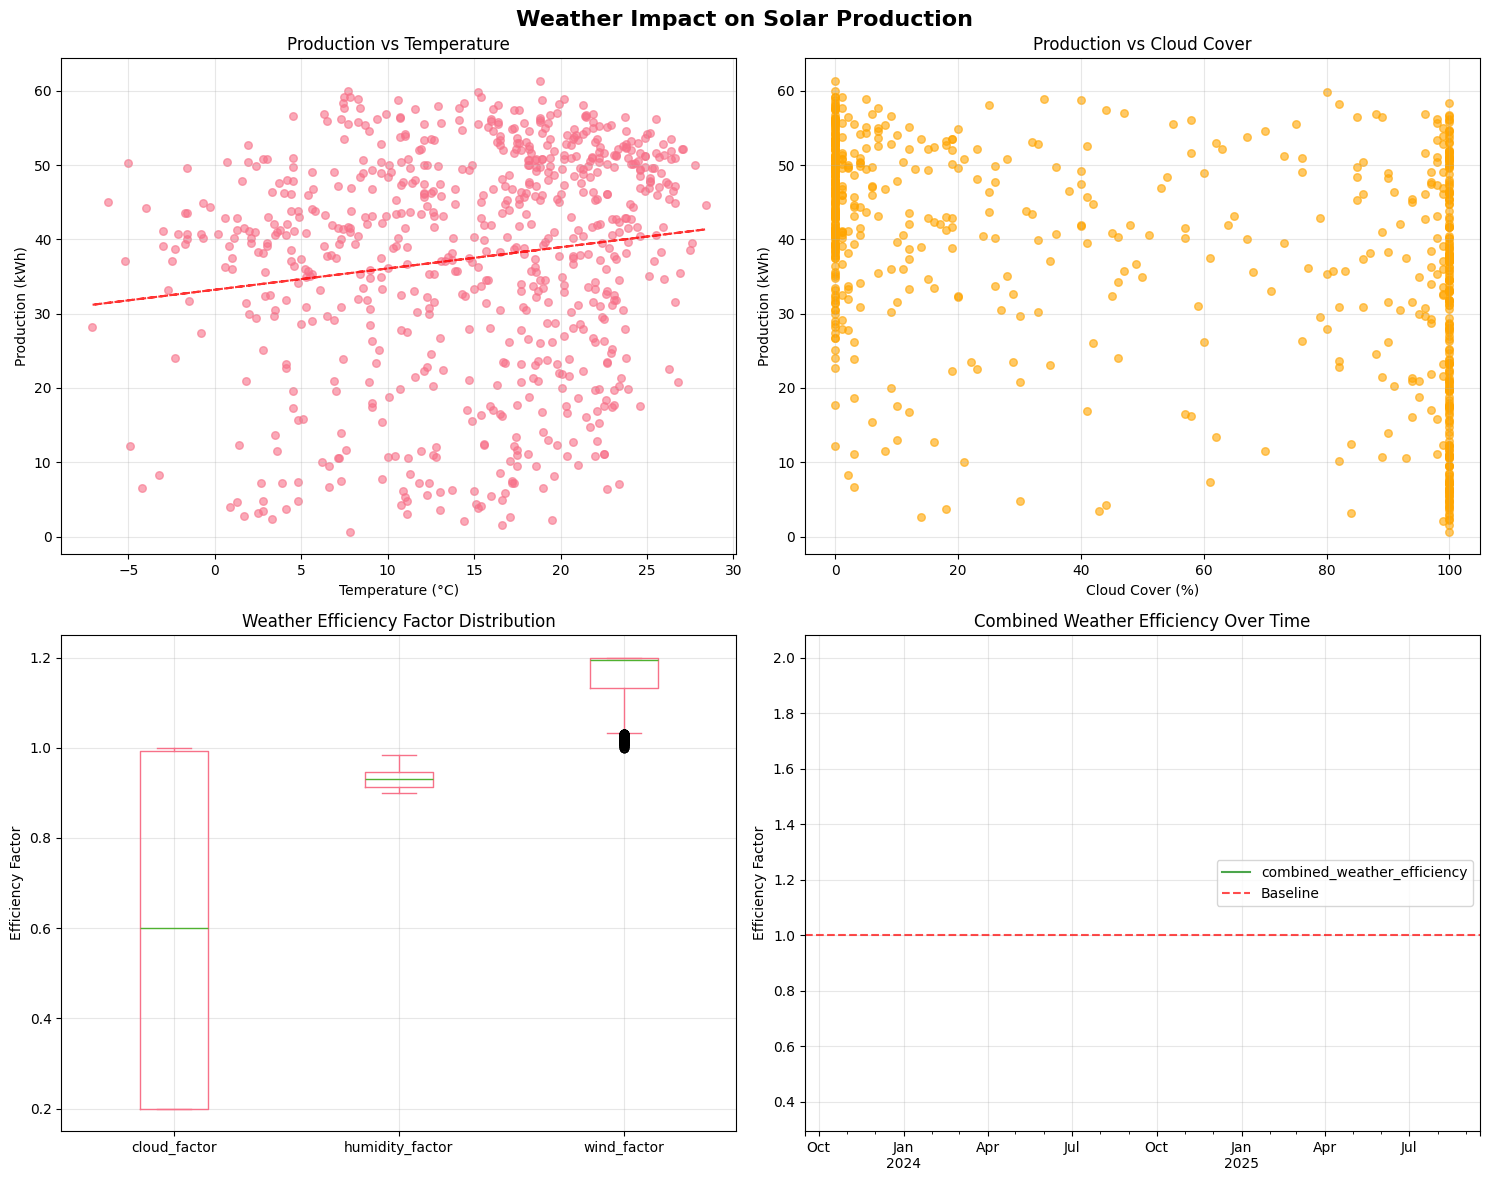

✅ Weather impact visualizations created


In [9]:
# Create visualizations if we have weather data
if historical_weather and not efficiency_data.empty:
    print("📊 Creating Weather Impact Visualizations...")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Weather Impact on Solar Production', fontsize=16, fontweight='bold')
    
    # 1. Production vs Temperature
    weather_df = weather_analyzer._weather_to_dataframe(historical_weather)
    merged_data = weather_analyzer._merge_production_weather(
        daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
        weather_df
    )
    
    if not merged_data.empty:
        # Temperature vs Production - clean data first
        temp_prod_clean = merged_data[['temperature', 'production']].dropna()
        
        if len(temp_prod_clean) > 1:
            axes[0,0].scatter(temp_prod_clean['temperature'], temp_prod_clean['production'], alpha=0.6, s=30)
            axes[0,0].set_xlabel('Temperature (°C)')
            axes[0,0].set_ylabel('Production (kWh)')
            axes[0,0].set_title('Production vs Temperature')
            axes[0,0].grid(True, alpha=0.3)
            
            # Add trend line with properly aligned data
            z = np.polyfit(temp_prod_clean['temperature'], temp_prod_clean['production'], 1)
            p = np.poly1d(z)
            axes[0,0].plot(temp_prod_clean['temperature'], p(temp_prod_clean['temperature']), "r--", alpha=0.8)
        
        # Cloud Cover vs Production - clean data first
        cloud_prod_clean = merged_data[['cloud_cover', 'production']].dropna()
        
        if len(cloud_prod_clean) > 1:
            axes[0,1].scatter(cloud_prod_clean['cloud_cover'], cloud_prod_clean['production'], alpha=0.6, s=30, color='orange')
            axes[0,1].set_xlabel('Cloud Cover (%)')
            axes[0,1].set_ylabel('Production (kWh)')
            axes[0,1].set_title('Production vs Cloud Cover')
            axes[0,1].grid(True, alpha=0.3)
        
        # Weather Efficiency Factors
        efficiency_cols = [col for col in ['cloud_factor', 'humidity_factor', 'wind_factor'] if col in efficiency_data.columns]
        if efficiency_cols:
            efficiency_data[efficiency_cols].plot(kind='box', ax=axes[1,0])
            axes[1,0].set_title('Weather Efficiency Factor Distribution')
            axes[1,0].set_ylabel('Efficiency Factor')
            axes[1,0].grid(True, alpha=0.3)
        
        # Combined Efficiency over Time
        if 'combined_weather_efficiency' in efficiency_data.columns:
            efficiency_data['combined_weather_efficiency'].plot(ax=axes[1,1], color='green', alpha=0.7)
            axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Baseline')
            axes[1,1].set_title('Combined Weather Efficiency Over Time')
            axes[1,1].set_ylabel('Efficiency Factor')
            axes[1,1].grid(True, alpha=0.3)
            axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Weather impact visualizations created")
    
else:
    print("⚠️ Skipping visualizations - insufficient weather data")

## 📋 Comprehensive Weather Report

Let's generate a comprehensive weather impact report that summarizes all our findings.

In [10]:
if historical_weather:
    print("📋 Generating Comprehensive Weather Report...")
    
    try:
        # Generate comprehensive report
        weather_report = weather_analyzer.generate_weather_report(
            daily_data[['Production (kWh)']].rename(columns={'Production (kWh)': 'production'}),
            historical_weather,
            forecast_weather if forecast_weather else None
        )
        
        print(f"\n📊 COMPREHENSIVE WEATHER IMPACT REPORT")
        print(f"=" * 50)
        print(f"Generated: {weather_report['timestamp'][:19]}")
        print(f"Location: {location.location_name} ({location.latitude:.3f}, {location.longitude:.3f})")
        
        # Analysis period
        period = weather_report['analysis_period']
        print(f"\n📅 Analysis Period:")
        print(f"   From: {period['start'][:10]}")
        print(f"   To: {period['end'][:10]}")
        print(f"   Duration: {period['days']} days")
        
        # Key correlations
        if 'correlation_analysis' in weather_report and 'correlations' in weather_report['correlation_analysis']:
            print(f"\n🔗 Key Weather Correlations:")
            correlations = weather_report['correlation_analysis']['correlations']
            
            # Sort by absolute correlation strength
            sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)
            
            for param, data in sorted_corr[:5]:  # Top 5 correlations
                corr = data['correlation']
                strength = data['strength']
                impact = "Positive" if corr > 0 else "Negative"
                print(f"   {param.replace('_', ' ').title()}: {corr:+.3f} ({strength} {impact} Impact)")
        
        # Efficiency summary
        if 'efficiency_summary' in weather_report:
            eff = weather_report['efficiency_summary']
            print(f"\n⚡ Weather Efficiency Summary:")
            print(f"   Average efficiency: {eff['average_efficiency']:.2f}")
            print(f"   Best performance: {eff['best_efficiency_day']:.2f}")
            print(f"   Worst performance: {eff['worst_efficiency_day']:.2f}")
            print(f"   Efficiency range: {eff['best_efficiency_day'] - eff['worst_efficiency_day']:.2f}")
        
        # Optimal conditions
        if 'optimal_conditions' in weather_report:
            print(f"\n🌟 Optimal Weather Conditions:")
            opt_conditions = weather_report['optimal_conditions']
            
            for param in ['temperature', 'cloud_cover', 'humidity', 'wind_speed']:
                if param in opt_conditions:
                    opt_range = opt_conditions[param]['optimal_range']
                    units = {'temperature': '°C', 'cloud_cover': '%', 'humidity': '%', 'wind_speed': ' m/s'}.get(param, '')
                    
                    print(f"   {param.replace('_', ' ').title()}: {opt_range['min']:.1f} - {opt_range['max']:.1f}{units} (optimal)")
        
        # Forecast summary
        if 'forecast' in weather_report:
            forecast = weather_report['forecast']
            print(f"\n📈 7-Day Forecast Summary:")
            print(f"   Total predicted production: {forecast['next_7_days_total']:.1f} kWh")
            print(f"   Daily average: {forecast['daily_average']:.1f} kWh")
            print(f"   Best production day: {forecast['best_day'][:10]}")
            print(f"   Lowest production day: {forecast['worst_day'][:10]}")
        
        print(f"\n" + "=" * 50)
        print(f"🎯 Weather analysis complete! Use this data to optimize your solar system performance.")
        
    except Exception as e:
        print(f"⚠️ Error generating weather report: {e}")
        
else:
    print("⚠️ Skipping comprehensive report - no historical weather data available")

📋 Generating Comprehensive Weather Report...

📊 COMPREHENSIVE WEATHER IMPACT REPORT
Generated: 2025-09-23T18:37:31
Location: Holly Springs, NC (35.668, -78.850)

📅 Analysis Period:
   From: 2023-09-16
   To: 2025-09-16
   Duration: 732 days

🔗 Key Weather Correlations:
   Cloud Cover: -0.434 (Moderate Negative Impact)
   Humidity: -0.265 (Weak Negative Impact)
   Temperature: +0.146 (Very Weak Positive Impact)
   Wind Speed: -0.099 (Very Weak Negative Impact)
   Pressure: -0.088 (Very Weak Negative Impact)

⚡ Weather Efficiency Summary:
   Average efficiency: 1.25
   Best performance: 2.00
   Worst performance: 0.37
   Efficiency range: 1.63

🌟 Optimal Weather Conditions:
   Temperature: 10.7 - 19.9°C (optimal)
   Cloud Cover: 0.0 - 73.8% (optimal)
   Humidity: 52.0 - 76.8% (optimal)
   Wind Speed: 8.8 - 15.0 m/s (optimal)

📈 7-Day Forecast Summary:
   Total predicted production: 5673.1 kWh
   Daily average: 33.8 kWh
   Best production day: 2025-09-23
   Lowest production day: 2025-09-

## 🚀 Next Steps & Recommendations

Congratulations! You've successfully integrated weather data into your solar analysis. Here are some recommendations for getting even more value from weather-enhanced forecasting:

In [11]:
print("🚀 WEATHER INTEGRATION SUCCESS!")
print("=" * 50)

print("\n✅ What You've Accomplished:")
print("   • Integrated free weather APIs for solar forecasting")
print("   • Analyzed weather correlation with solar production")
print("   • Created weather-aware ML prediction models")
print("   • Generated 7-day production forecasts")
print("   • Identified optimal weather conditions")

print("\n🎯 Recommendations for Enhanced Accuracy:")
print("   1. 🔑 Add OpenWeatherMap API key for solar-specific data")
print("      • More accurate solar irradiance forecasts")
print("      • Panel-specific tilt and azimuth calculations")
print("      • Professional-grade weather models")

print("\n   2. 📊 Improve ML Models with More Data")
print("      • Add more historical production data (6+ months)")
print("      • Include microinverter data for panel-level analysis")
print("      • Incorporate equipment specifications")

print("\n   3. ⚡ Optimize Energy Usage")
print("      • Schedule high-energy activities on sunny days")
print("      • Use battery storage for cloudy day preparation")
print("      • Implement time-of-use rate optimization")

print("\n   4. 🔄 Automation Opportunities")
print("      • Set up daily weather-based production alerts")
print("      • Integrate with home automation systems")
print("      • Create maintenance scheduling based on weather")

print("\n📧 Configuration:")
print("   Add to your .env file for enhanced features:")
print("   OPENWEATHER_API_KEY=your_api_key_here")

print("\n🌟 You now have professional-grade solar forecasting capabilities!")
print("   Use the weather_manager and weather_analyzer modules in other notebooks")
print("   for continued analysis and optimization.")

🚀 WEATHER INTEGRATION SUCCESS!

✅ What You've Accomplished:
   • Integrated free weather APIs for solar forecasting
   • Analyzed weather correlation with solar production
   • Created weather-aware ML prediction models
   • Generated 7-day production forecasts
   • Identified optimal weather conditions

🎯 Recommendations for Enhanced Accuracy:
   1. 🔑 Add OpenWeatherMap API key for solar-specific data
      • More accurate solar irradiance forecasts
      • Panel-specific tilt and azimuth calculations
      • Professional-grade weather models

   2. 📊 Improve ML Models with More Data
      • Add more historical production data (6+ months)
      • Include microinverter data for panel-level analysis
      • Incorporate equipment specifications

   3. ⚡ Optimize Energy Usage
      • Schedule high-energy activities on sunny days
      • Use battery storage for cloudy day preparation
      • Implement time-of-use rate optimization

   4. 🔄 Automation Opportunities
      • Set up daily weat